In [2]:
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import misc
from sklearn.cluster import KMeans
import seaborn as sns
from numpy import linalg as la
from math import floor
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider
from ipywidgets import IntSlider
plt.rcParams['figure.figsize'] = (20, 10)
from mpl_toolkits import mplot3d

![](lineas.png)

# Basic but not standard image processing

## Introduction

Humans process visual data in almost miracolous ways, it can adjust contrast and brightness, it can even recognize and track objects or faces to mention some of its capabilities, all of them in real time. 

We do not know precisely how the brain does most of its analysis, however when finding the necessity to process images in computers some good abstractions can be made. Lets start with the most generalized definition of black and white images:

First we define $A =[0,m]$ x $[0,n] \in \mathbb{R}^2$ 
which in english corresponds to a rectangle of height m and width n, which we can refer to as the canvas. Given this, our image $img$ can be defined as:

* $img\colon \begin{array}{>{\displaystyle}l} A \rightarrow \mathbb{R} \\  (x,y)\mapsto img(x,y) \in [0,1] \end{array} $ 

This means that every point in the canvas is asigned with a value in the grey scale. Where 0 is white and 1 is black as seen in the following palette:

<Figure size 432x288 with 0 Axes>

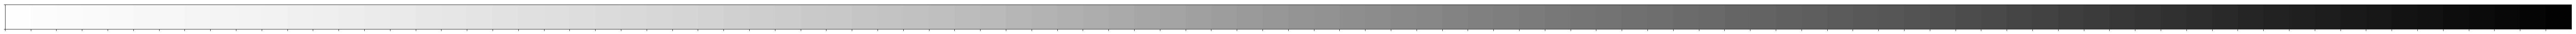

In [25]:
fig=plt.figure()
sns_plot=sns.palplot(sns.color_palette("Greys",100))

This definition is impossible for a computer to handle because of the discrete nature of computers, however it is the way to formalize further analysis and processing. To mention some examples, you are able to differentiate an image, or apply any mapping or filtering which could result in an interesting transformation.([Computer vision](https://en.wikipedia.org/wiki/Computer_vision))

To mention some of these you have [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator), [Image Fourier transforms](https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm) and [convolutional filters](http://aishack.in/tutorials/image-convolution-examples/).

A definition which can be handled in a computer is made as follows:

* A b&w image $img$ is a real $m*n$ matrix. Where $m$ and $n$ are the number of pixel rows and columns and $img(i,j)\in [0,1] $. This matrix is then handled as a 2d float array in your favourite programming language.

All of it is only a discretization of the previous definition.

For example, lets say that $m,n=1000$ and we choose random values for every $img(i,j)$:

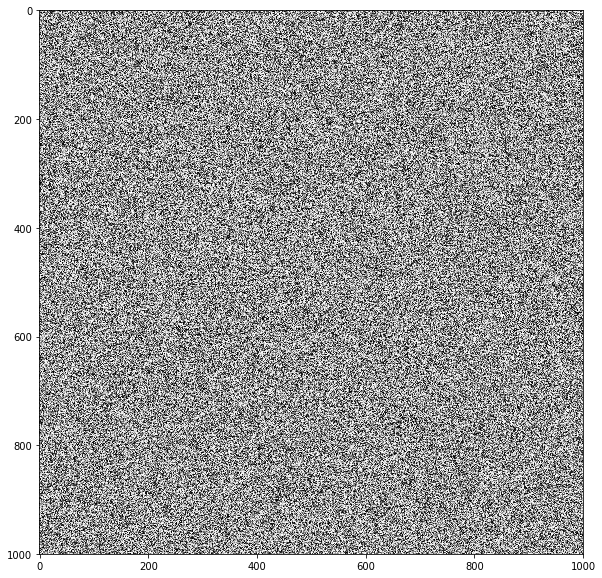

In [21]:
img=np.random.random((1000,1000))
ax=plt.imshow(img,cmap='Greys')

Which turns out to be a black and white $1000*1000$ pixel noisy image.

It gets a little bit more complicated for a color image, one definition corresponds to:

* A color image $img$ of $m*n$ size corresponds to a real valued tensor or in other words a real multidimensional array of dimensions $m*n*3$. Again having $m$ and $n$ as the number of pixel rows and columns and $img(i,j,k)\in [0,1] $, in this case a value of 0 or 1 is not so easy to interpret as each of the entries of the last dimension corresponds to a scale of red, green or blue.

* An easier way to understand this $img$ definition is having RGB pixels or $\mathbb{R}^3$ vectors with an assigned $(i,j)$ position in a given $m*n$ matrix or "canvas".

At this point it is important to mention that RGB is only one of the abstractions of color spaces around, there is [CMYK](https://en.wikipedia.org/wiki/CMYK_color_model),[HSV and HSL](https://en.wikipedia.org/wiki/HSL_and_HSV) and [CIELAB](https://en.wikipedia.org/wiki/CIELAB_color_space) to mention some.

With the following code you are able to interact with the RGB cube as you wish.

In [1]:
def f(R,G,B):
    sns.palplot([R,G,B])
    return (R,G,B)
interact(f, R=FloatSlider(min=0, max=1, step=.05, value=.6,continuous_update=False),G=FloatSlider(min=0, max=1, step=.05, value=0.1,continuous_update=False),B=FloatSlider(min=0, max=1, step=.05, value=.4,continuous_update=False));

NameError: name 'interact' is not defined

If you did not interact enough, some good intuition of the RGB cube space is:
* $(0,0,0)$ is black.
* $(1,1,1)$ is white.
* each of the $e_i$ is red, green and blue, where $e_i$ is the unitary vector in axis $i$.

Now that we know the basics of how images are represented lets try to load one. With the following code we are able to open most of the computer representation of images in this case $.jpg$ which is the above definition with some metadata and (compression?) added.

/Users/jeroaranda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


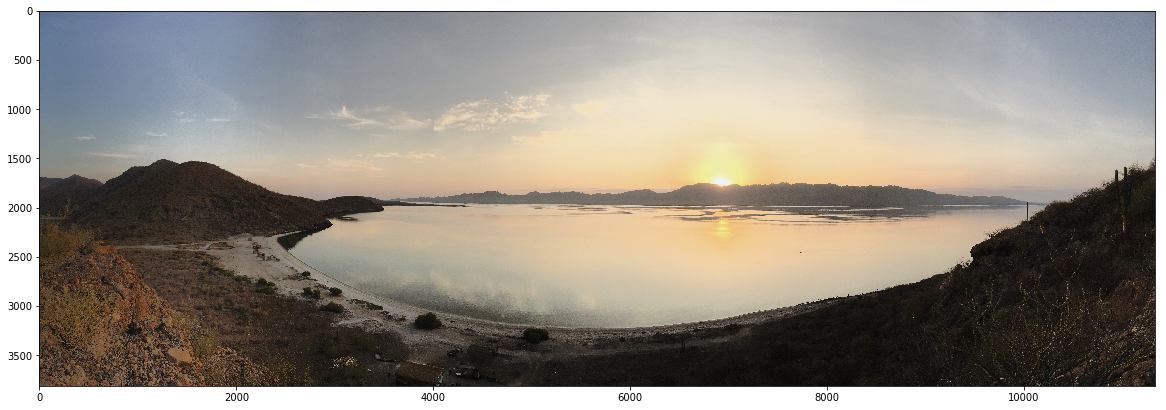

In [5]:
img=misc.imread('../E1D73264-0143-42C7-B511-562343FB6D27.jpg')
plt.imshow(img)

the $img$ object returned by .imread() is an ndarray, which is just a multidimensonal array.

The following code prints the dimension sizes:

In [35]:
ysize=img.shape[0]
xsize=img.shape[1]
zsize=img.shape[2]
print(f'{ysize} {xsize} {zsize}')

3812 11340 3


which correspond to row pixels, column pixels and RGB channel. 

## Cutting panoramic images into squares for instagram feed.

Now we know the basics of an image, we will try to do some easy processing with our image data. As some of you may know instagram allows users to upload preferrably square images, and recently it got a feature where you are able to post multiple images in a single post. If you are able to cut a panoramic image in multiple sequential squares you can upload it as a multiple image post and be able to slide it smoothly.

For our algorithm we will first find out how many complete squares can our original image be cut into. Then we are just slicing the original image  in squares and fitting them into this individual squares. Each square will have side $ysize$.

If our panoramic image cant't be cut complete in perfect squares we will have a last image with the end of it as a rectangle. This rectangle will be fitted into a white square.

For this we are going to use the following code:

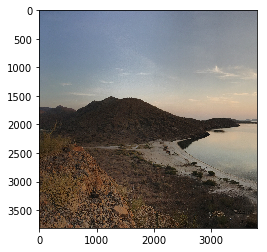

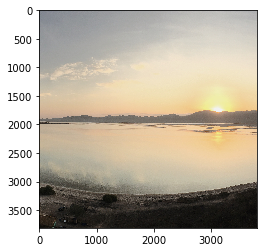

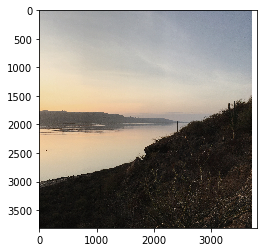

In [36]:
for i in range(floor(xsize/ysize)):
    new_img=np.ndarray(shape=(ysize,ysize,3), dtype=int, order='F')
    slicer=(slice(0, ysize, 1), slice(i*ysize,(i+1)*ysize, 1), slice(0, 3, 1))
    new_img=img[slicer]
    plt.figure(i)
    plt.imshow(new_img, cmap=plt.cm.gray)
    #misc.imsave(f'panoramica{i}.jpg', new_img)


new_img=np.ones((ysize,ysize,3),dtype=int)*255
slicer1=(slice(0, ysize, 1), slice((i+1)*ysize,xsize, 1), slice(0, 3, 1))
slicer2=(slice(0, ysize, 1), slice(0,xsize%ysize, 1), slice(0, 3, 1))
new_img[slicer2]=img[slicer1]
plt.figure(i+1)
plt.imshow(new_img, cmap=plt.cm.gray)
#misc.imsave(f'panoramica{i+1}.jpg', new_img) 

As you can see, most of the hard work was done by the $slice$ objects which allows you to extract rectangular or square regions of our original image. The slice object is initialized as $slice(i,j,step)$, $i$ is the index for the start, $j$ for the end and $step$ helps you choose how dense your uniform sample is. You can also implement it as $i:j:step$ in some cases.

You can find the instagram result [here](https://www.instagram.com/p/B1JkQuzlbhlYmrDZ4oHoGzWUwWPkMBCecROnII0/).


## Getting the color palette of an image with K-means

In this section we are going to read a different image and we will try to extract its color "palette" whatever this means, I believe is somekind of human spectrography?, for sure it reveals the content of whatever atom is inside that. The color palette can be interpreted as a sample of representative colors from a given image, in this approach I will get these representative colors using the $medians$ of the clusters labeled by the K-means algorithm.

In easy words the K-means algorithm starts by us manually choosing the number of clusters $n$ we want our data to be labeled by. In this case we are using the $(RGB)$ data of all our image, sometimes it can be interesting to label the $(RGB,i,j)$ data which will clusterize not only by color but also by the given x and y pixel position.

After choosing $n$ the algorithm will randomly select $n$ cluster centers and iteratively try to improve the $RGB$ clusterization. In each iteration the algorithm labels each $RGB$ point to its closest (euclidean distance) center, and after this recalculates each cluster center as the mean of the cluster. This is done until the new centers stop moving, or better stated, when each of the new centers is in a sufficently small neigbourhood of the previous centers.

This is done with the following code:

/Users/jeroaranda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


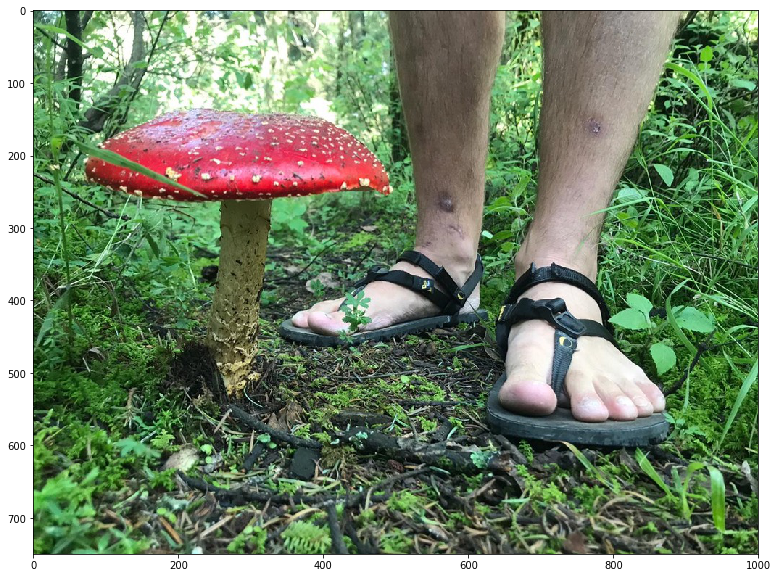

In [6]:
img=misc.imread('../C712DD03-E345-459E-928F-A9949A247E75-1000.jpg')
plt.imshow(img)
ysize=img.shape[0]
xsize=img.shape[1]


Which will again load an image and its current size. And then:

In [74]:
n=30
new_img=np.reshape(img,(xsize*ysize,3))
model=KMeans(n_clusters=n,random_state=6).fit(new_img)

In [92]:
new_img=np.reshape(img,(xsize*ysize,3))

Which first chooses $n$ as the number of colors for the palette. And then run the K-means algorithm until it converges. To obtain the following palette:

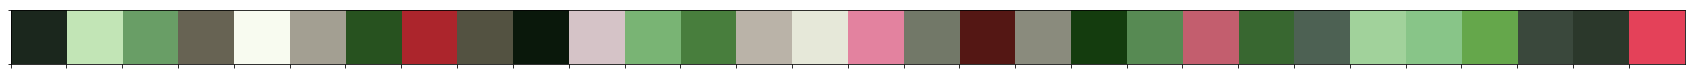

In [103]:
colors=[]
for i in range(n):
    colors.append(np.median(new_img[model.labels_==i],axis=0))
    colors[i]=colors[i]/255
sns.palplot(colors)

## Experimenting with the palete

In [2]:
color_id=29
def f(R,G,B):
    colors[color_id]=(R,G,B)
    sns.palplot(colors)
    new_img=np.zeros((xsize*ysize,3))
    for i in range(n):
        slicer=model.labels_==i
        new_img[slicer]=colors[i]
    new_img=np.reshape(new_img,(ysize,xsize,3))
    plt.figure()
    plt.imshow(new_img, cmap=plt.cm.gray) 
#misc.imsave(f'new_img.jpg', new_img) If you want to save the new image.
    return (R,G,B)
interact(f, R=FloatSlider(min=0, max=1, step=.05, value=colors[color_id][0],continuous_update=False),G=FloatSlider(min=0, max=1, step=.05, value=colors[color_id][1],continuous_update=False),B=FloatSlider(min=0, max=1, step=.05, value=colors[color_id][2],continuous_update=False));

NameError: name 'colors' is not defined

# Reconstructing the palete
As the data is labeled we just find out the median of each cluster as it may be more robust than the mean, and after some scaling, the palette is printed.

In the next block of code we will reconstruct the original image but painting it with only the palette colors. 

This means:
* if $img(i,j)$ was labeled by the K-means to be part of cluster number $k$ then $new$_$img(i,j)=palette[k]$. Assuming that each of the previous colors in the palette are indexed in an RGB array of size $n$, remember $n$ was the number of clusters we wanted our data to be classified.

It can be stated more clear with the following python code:

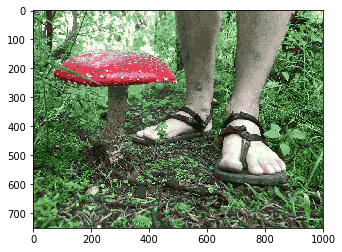

In [105]:
new_img=np.zeros((xsize*ysize,3))
for i in range(n):
    slicer=model.labels_==i
    new_img[slicer]=colors[i]
new_img=np.reshape(new_img,(ysize,xsize,3))
plt.imshow(new_img, cmap=plt.cm.gray) 
#misc.imsave(f'new_img.jpg', new_img) If you want to save the new image.

In this example we used a different kind of $slice$, which is a boolean array for indexing each cluster, this slicer is then used to paint each of the image clusters, slices or segments with the color in the palette they had assigned.

Of course when the previous image is saved it uses the previous definition of an $ndarray$ of $(m*n*3)$ dimensions, with this already clustered information we could develop a data structure with exactly the same information as that new image file but just by saving the assigned labels, the resulting color palette and the original $m*n$ dimensions. Some kind of topological RGB compression I guess? Luminosity order of the palette seems to be also an interesting information for reconstruction used later.

### Transfering a color palete

To transfer a sequential palette, one that keeps luminosity order, we will first get the luminosity order from our clusterized image.

In the following lines, I tried a way to order the palete by luminosity, if you have some understanding of the RGB colors, luminosity can be interpretted as the $norm$ of your RGB vector. Specially the norm of the projection of your color vector to the $(1,1,1)$ vector. This process is basically computing the euclidean norms and using them to reorder the previous palete.



[0.21802652 1.37647059 0.84466801 0.64793761 1.67348088 1.06075351
 0.37626628 0.7111892  0.52376069 0.11071054 1.37531933 0.96455443
 0.61733263 1.20782404 1.53800002 1.20047408 0.76658392 0.35042677
 0.91120582 0.25402564 0.71778634 0.95223083 0.49680254 0.58465578
 1.20262433 1.07968555 0.81992676 0.43222732 0.32418828 0.99309419]


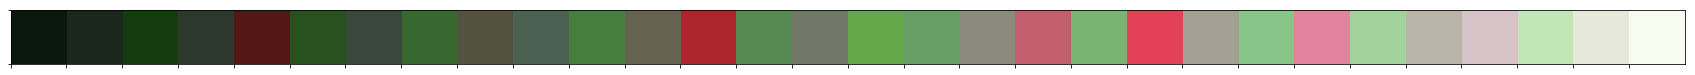

In [51]:
new_colors=np.array(colors)
normas=la.norm(colors,axis=1)
print(normas)
map_id=np.argsort(normas).astype(int)
new_colors[:,0]=new_colors[map_id,0]
new_colors[:,1]=new_colors[map_id,1]
new_colors[:,2]=new_colors[map_id,2]
sns.palplot(new_colors)

The following code will get a different palette and use it to reconstruct the image.

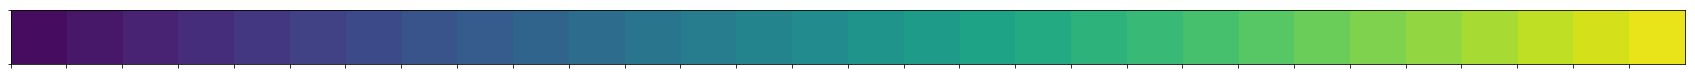

In [52]:
new_colors=sns.color_palette("viridis",n)
new_colors=np.array(new_colors)
sns.palplot(new_colors)

The code basically gets the new sequential palette and orders it with the previously extracted luminosity order. The following code is exactly the same previous reconstruction but with the transfered palette, I guess it to be some kind of transfer learning? Specially if you use palettes from graphic artists or so.

/Users/jeroaranda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()


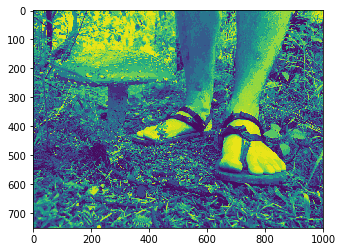

In [53]:
map_id=np.argsort(map_id)
new_colors[:,0]=new_colors[map_id,0]
new_colors[:,1]=new_colors[map_id,1]
new_colors[:,2]=new_colors[map_id,2]
new_img=np.zeros((xsize*ysize,3))
for i in range(n):
    slicer=model.labels_==i
    new_img[slicer]=new_colors[i]
new_img=np.reshape(new_img,(ysize,xsize,3))
plt.imshow(new_img, cmap=plt.cm.gray) 
misc.imsave(f'new_img.jpg', new_img)

## Getting the sky color palette and adding it to the original image

Again the first step will be reading the image in a `numpy`array.

/Users/jeroaranda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


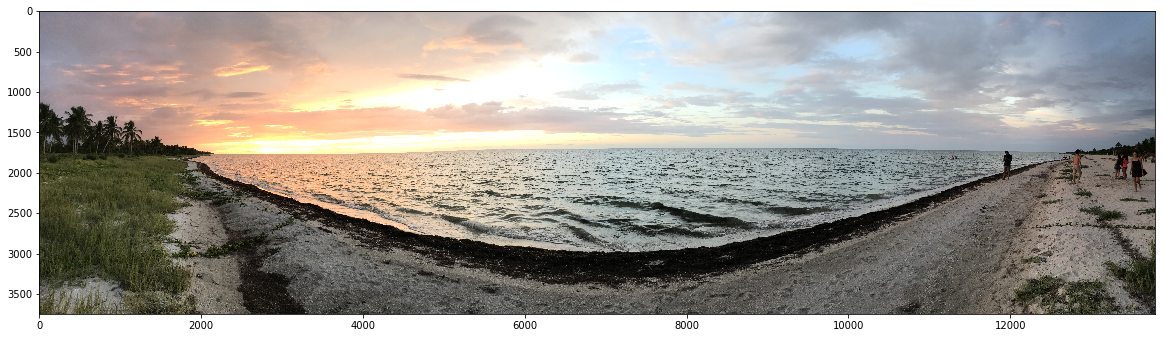

In [6]:
img=misc.imread('IMG_2453.jpeg')
ysize=img.shape[0]
xsize=img.shape[1]
plt.imshow(img)


The following code gets the median RGB color of every column in the img slice given by:
```python 
img[500:1600,:,:]
```
then it creates a new image that will include the obtained gradient in the bottom of it.

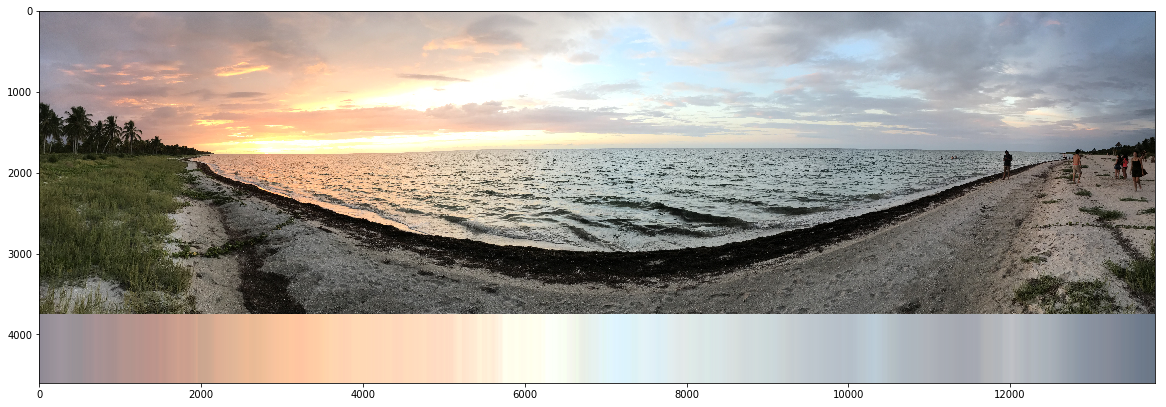

In [7]:
colors=[]
for i in range(xsize):
    colors.append(np.median(img[500:1600,i,:],axis=0))
    colors[i]=colors[i]/255
    #new_img[model.labels_==i]=colors[i]
colors=np.array(colors)
new_img=np.zeros((ysize+856,xsize,3))
for i in range(xsize):
    new_img[-856:ysize+856,i,:]=colors[i,:]
new_img[0:ysize,:,:]=img/255
plt.imshow(new_img)

Which appears to be similar to the `'coolwarm'` `matplotlib` color palette:

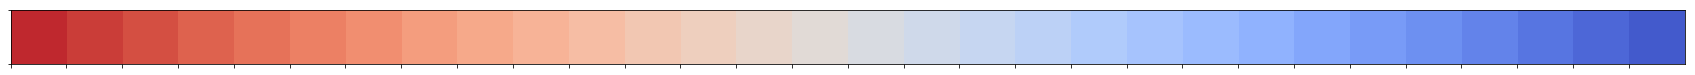

In [17]:
sns.palplot(sns.color_palette("coolwarm", 30)[::-1])

# Gaussian kernels

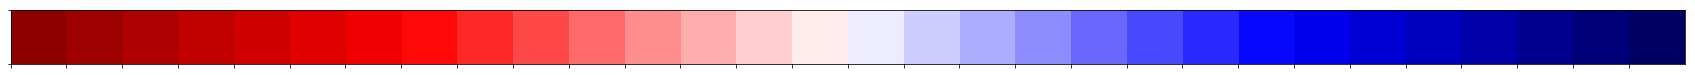

In [3]:
sns.palplot(sns.color_palette("seismic", 30)[::-1])

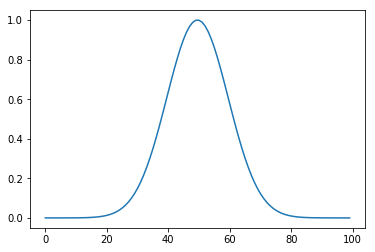

In [4]:
kern= signal.gaussian(100, std=10).reshape(100,1)
plt.plot(range(100),kern)

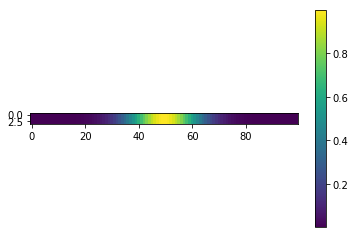

In [5]:
fig, ax = plt.subplots()


# repeat everything above for the negative data






axis=np.zeros((4,100))
for i in range(100):
    axis[:,i]=kern[i]
neg=ax.imshow(axis,cmap='viridis')
fig.colorbar(neg, ax=ax)
plt.imsave('axis.png',axis,cmap='seismic')

In [6]:

kern_repetitions=np.zeros((1000,1))
for i in range(19):
    kern_repetitions[(i*50):(i*50)+100]+=(-1)**i*kern
kern= signal.gaussian(1000, std=100).reshape(1000,1)
kern_repetitions-=kern

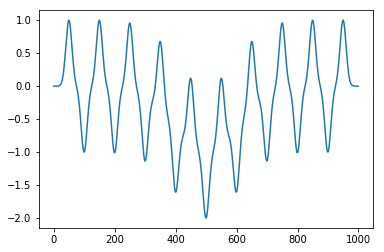

In [7]:
plt.figure()
plt.plot(range(1000),kern_repetitions)

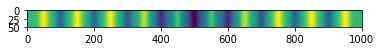

In [8]:
axis=np.zeros((50,1000))
for i in range(1000):
    axis[:,i]=kern_repetitions[i]
plt.imshow(axis,cmap='viridis')
#plt.imsave('axis.png',axis,cmap='seismic')

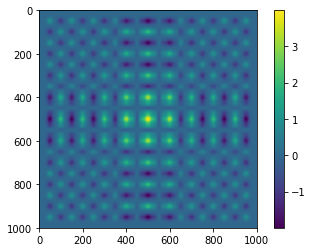

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = plt.subplots()
img=np.outer(kern_repetitions, kern_repetitions)
plt.figure()
neg=ax.imshow(img,cmap='viridis')
fig.colorbar(neg,ax=ax)
#plt.imsave('heatmap.png',img,cmap='seismic')

In [11]:
%matplotlib inline

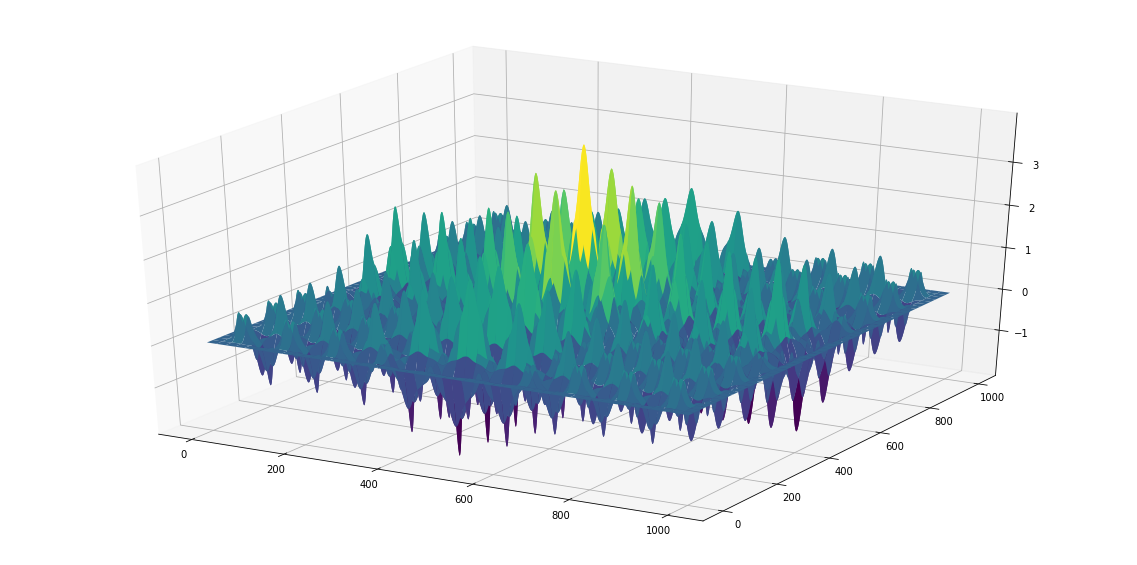

In [13]:
plt.rcParams['figure.figsize'] = (20, 10)
X,Y=np.meshgrid(range(1000),range(1000))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, img,cmap='viridis')

## Conclusions

Basic image processing may be really easy with high level tools as photoshop, however understanding some basics for computer image handling may open your eyes to developing by yourself any filtering, analysis or transformation that you can imagine. I reccomend taking a course in computer vision to further develop your skills in image processing or just experiment with the already developed libraries there exist.

If you are interested in the notebook find it [here](https://github.com/jeroaranda/notebooks/blob/master/basic_but_not_standard.ipynb)  in a git repository or in my instagram account [here](https://www.instagram.com/jeroaranda/).

## References

* For the Python libraries you can see them in the imports at the beggining of the notebook,but the most importants are:
    * [scipy](https://www.scipy.org) for the image stuff.
    * [numpy](https://numpy.org) for the numeric stuff.
    * [sklearn](https://scikit-learn.org/stable/index.html) for the K-means.
    * [seaborn](https://seaborn.pydata.org) for the cool palette displays.
    * [matplotlib](https://matplotlib.org) for the grapics.
    
* [Computer vision course](https://cecs.anu.edu.au/research/information/computer-vision)  at ANU engineering.